# Assignment 1: Performance Evaluation of Self-Service Buffet Queuing System
## Course: System Performance Evaluation (CO3007)
## Group: Iron Sentinel

# 1. Team work declaration

## Team
| Student             | Id      |
|---------------------|---------|
| Lê Ngọc An          | 2252007 |
| Nguyễn Ngọc Duy     | 2252118 |
| Trương Phú Cường    | 2252100 |
| Vũ Trịnh Thanh Bình | 2252085 |
| Cao Võ Hoài Phúc    | 2053332 |
| Võ Hoàng Long       | 2053192 |

## Workmap declaration

| Last name | Student ID | Design Role | Dev Role | Eval Role | Report Role | Ass1 work description (details in text) | Rating | week 2 outcome | week 3 outcome | week 4 outcome |
|-----------|------------|-------------|----------|-----------|-------------|------------------------------------------|-----------------|----------------|----------------|-----------------|
| Cường | 2252100 | **YES** | no | no | yes | **Platoon 1:** Defined system architecture, parameter mapping, and wrote Phase 1 report. | A | Done | | |
| Bình | 2252085 | **YES** | no | no | yes | **Platoon 1:** Designed the Buffet feedback loop logic and workload definitions. | A | Done | | |
| An | 2252007 | no | **YES** | no | yes | **Platoon 2:** Implemented SimPy code structure (ServiceStation class) and run simulation. | A | | Done | |
| Duy | 2252118 | no | **YES** | no | yes | **Platoon 2:** Implemented Workload configurations and data collection logic. | A | | Done | |
| Phúc | 2053332 | no | no | **YES** | yes | **Platoon 3:** Validated simulation results, identified system limitations, reviewed 5 external groups. | A | | | Done |
| Long | 2053192 | no | no | **YES** | yes | **Platoon 3:** Analyzed simulation metrics, wrote conclusions, reviewed 5 external groups. | A | | | Done |


# 2. System Design

## System Performance Steps

### 1. Define Goal and System
* **Goal:** To evaluate the performance metrics (waiting time, queue length, throughput) of a "Self-service Buffet System" under various traffic conditions.
* **System Model:** The system is modeled as an **Open Queuing Network with a Feedback Loop**, representing customers returning for more food.

### 2. Service and Outcomes
The service process consists of 4 sequential stages with a feedback mechanism:
1.  **Arrival & Waiting:** Customers arrive and wait at the entrance if necessary.
2.  **Food Service:** Customers proceed sequentially through 3 counters: **Appetizer $\to$ Main Course $\to$ Dessert**.
3.  **Dining:** Customers sit at a table to consume their meal.
4.  **Feedback Decision:** After dining, customers decide to either exit or re-queue for more food based on a probability ($\delta$).

### 3. Select Metrics
We selected the following metrics to assess system performance:
* **Average Time in System ($W$):** The total time a customer spends from arrival to exit.
* **Queue Length ($L_q$):** The number of customers waiting at each service station (to identify bottlenecks).
* **Server Utilization ($U$):** The percentage of time servers/tables are occupied.

### 4. List System Parameters
The system consists of 5 service stations, modeled as $M/M/c$ queues:

| Station Name | Real-world Entity | Servers ($c$) | Service Time Mean ($1/\mu$) |
| :--- | :--- | :--- | :--- |
| **Waiting** | Entrance | Multi-server | 0.5 mins |
| **Appetizer** | Food Counter 1 | Multi-server | 1.0 mins |
| **Main Course** | Food Counter 2 | Multi-server | 1.5 mins |
| **Dessert** | Food Counter 3 | Multi-server | 0.8 mins |
| **Dining** | Tables/Seats | Multi-server | 15.0 mins |
| **Decision** | Re-queue Probability | - | $\delta$ (0.15 - 0.20) |

### 5. List Factors to Study
The primary factor to be studied is the **Customer Arrival Rate ($\lambda$)**. We analyze how increasing the traffic load impacts system stability and waiting times.

### 6. Evaluation Technique
* **Technique:** Discrete-Event Simulation (DES).
* **Tool:** Python programming language with the **SimPy** library.

### 7. Select Workload
We defined two workloads to simulate different real-world scenarios:
* **Workload 1 (Off-peak Hours):** $\lambda = 1$ customer/minute. Used to establish baseline performance.
* **Workload 2 (Peak Hours):** $\lambda = 5$ customers/minute. Used to stress-test the system and observe congestion/bottlenecks.


## System Component/Module description

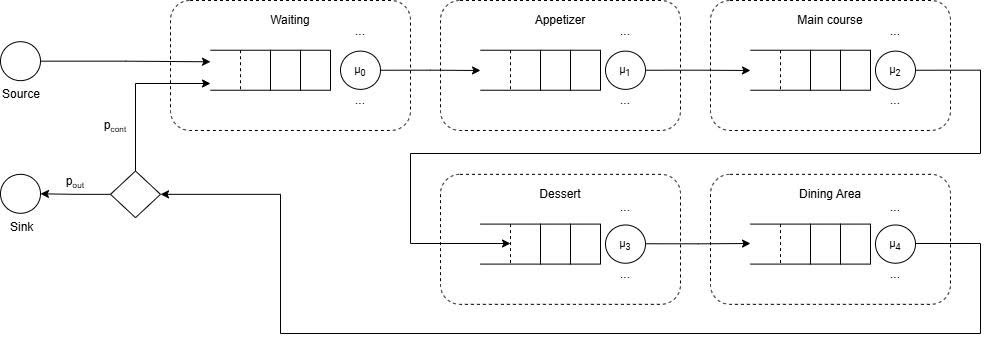

Based on the Phase 1 design, the simulation is structured around two primary Python classes:

### 1. Component: ServiceStation (The "Resource")
* **Role:** Represents a single service node (e.g., Entrance, Appetizer Counter, Dining Area).
* **Key Attributes:**
    * `num_servers` (c): Number of parallel servers/tables.
    * `mean_service_time` (1/µ): Average processing time per customer.
    * `resource`: A `simpy.Resource` object managing the queue and capacity.
* **Key Method:** `serve(customer)` - Handles the logic of requesting a resource, waiting in queue, and processing service.

### 2. Component: BuffetSimulation (The "Controller")
* **Role:** The main controller that manages the entire simulation lifecycle.
* **Key Responsibilities:**
    * **Initialization:** Sets up the SimPy environment and creates all Service Stations based on configuration.
    * **Customer Generation:** Implements the arrival process (Poisson distribution).
    * **Routing Logic:** Defines the customer journey: `Waiting` → `Food Counters` → `Dining` → `Decision (Re-queue/Exit)`.
    * **Data Collection:** Tracks waiting times, queue lengths, and server utilization for analysis.

# 3. System Implementation



Install prerequisite library


*   simpy



In [ ]:
!pip install simpy

## Queuing Node 1




In [ ]:
import simpy
import random
import statistics
import time


class ServiceStation:
    def __init__(self, env, num_servers, mean_service_time, queue_capacity=float('inf')):
        self.env = env
        self.num_servers = num_servers
        self.mean_service_time = mean_service_time
        self.queue_capacity = queue_capacity

        # Single shared queue feeding c servers (M/M/c model)
        self.resource = simpy.Resource(env, capacity=num_servers)

        self.wait_times = []
        self.service_times = []
        self.queue_lengths = []
        self.customers_served = 0

        # Track which server served each customer (for statistics)
        self.server_customers_served = [0 for _ in range(num_servers)]
        self.next_server = 0  # Round-robin assignment for tracking

    def has_available_queue(self):
        """Check if queue has space available"""
        # In M/M/c model, check if total queue length is below capacity
        return len(self.resource.queue) < self.queue_capacity

    def get_current_queue_length(self):
        """Get current queue length (customers waiting, not being served)"""
        return len(self.resource.queue)

    def get_current_in_service(self):
        """Get number of customers currently being served"""
        return self.resource.count

    def serve(self, customer_id):
        arrival_time = self.env.now

        # Record queue length when customer arrives
        queue_length = len(self.resource.queue)
        self.queue_lengths.append(queue_length)

        # Request service from the shared resource pool
        with self.resource.request() as request:
            yield request

            # Customer got a server
            wait_time = self.env.now - arrival_time
            self.wait_times.append(wait_time)

            # Assign to server (round-robin for tracking purposes)
            server_index = self.next_server
            self.next_server = (self.next_server + 1) % self.num_servers

            service_time = random.expovariate(1.0 / self.mean_service_time)
            self.service_times.append(service_time)

            yield self.env.timeout(service_time)

            self.customers_served += 1
            self.server_customers_served[server_index] += 1


## Queuing node 2


In [ ]:
class BuffetSimulation:
    def __init__(self):
        self.env = simpy.Environment()
        self.stations = {}
        self.customer_count = 0
        self.total_customers = 0
        self.completed_customers = 0
        self.requeue_count = 0
        self.customer_total_times = []
        self.waiting_area = []  # Queue for customers waiting to enter stations
        self.unmet_demand_returns = 0  # Count customers returning due to unmet demands
        self.customers_completed_dining = set()  # Track unique customers who finished dining
        self.customers_left_full_queue = 0  # Customers who left because waiting queue was full
        self.customers_left_excessive_wait = 0  # Customers who left after waiting > 20 minutes
        self.customers_in_service_stations = 0  # Track customers currently in service stations (not waiting/dining)
        self.customers_denied_requeue = 0  # Customers who left because they exceeded max time for requeue
        self.event_log = []  # Log of all customer events
        self.station_snapshots = []  # Snapshots of station conditions at each minute

    def log_event(self, event_type, customer_id, station_name="", details=""):
        """Log a customer event with timestamp"""
        self.event_log.append({
            'time': self.env.now,
            'event': event_type,
            'customer': customer_id,
            'station': station_name,
            'details': details
        })

    def capture_station_snapshot(self):
        """Capture current state of all stations"""
        snapshot = {'time': self.env.now}
        for name, station in self.stations.items():
            snapshot[name] = {
                'queue_length': len(station.resource.queue),
                'in_service': station.resource.count,
                'total_served': station.customers_served
            }
        self.station_snapshots.append(snapshot)

    def setup_stations(self, station_configs):
        for config in station_configs:
            queue_capacity = config.get('queue_capacity', float('inf'))
            station = ServiceStation(
                self.env,
                config['num_servers'],
                config['mean_service_time'],
                queue_capacity
            )
            self.stations[config['name']] = station
            if queue_capacity != float('inf'):
                capacity_str = f"total queue capacity = {queue_capacity}, total capacity  = {queue_capacity} "
            else:
                capacity_str = "unlimited queue"
            print(f"Station '{config['name']}': {config['num_servers']} servers, "
                  f"service time = {config['mean_service_time']:.2f} min, {capacity_str}")
        print()

    def get_total_waiting_queue_length(self):
        """Get total number of customers in waiting station queue"""
        return len(self.stations['waiting'].resource.queue)

    def get_total_service_station_customers(self):
        """Get total customers in appetizer, main_course, and dessert stations"""
        total = 0
        for station_name in ['appetizer', 'main_course', 'dessert']:
            # Count customers in queue + being served
            station = self.stations[station_name]
            total += len(station.resource.queue) + station.resource.count
        return total

    def get_dining_total_capacity(self):
        """Get total capacity of dining station"""
        station = self.stations['dining']
        # Total capacity = customers in queue + customers being served
        # In M/M/c: max queue size + number of servers
        if station.queue_capacity == float('inf'):
            return float('inf')
        return station.queue_capacity + station.num_servers

    def generate_service_requirement(self):
        """Generate service requirement in n/n/n format for appetizer/main_course/dessert"""
        while True:
            req = [
                random.choice([0, 1]),  # Appetizer
                random.choice([0, 1]),  # Main course
                random.choice([0, 1])   # Dessert
            ]
            # Ensure at least one station is required (not 0/0/0)
            if sum(req) > 0:
                return req

    def generate_arrivals(self, mean_arrival_time, requeue_prob):
        while True:
            yield self.env.timeout(random.expovariate(1.0 / mean_arrival_time))

            self.customer_count += 1
            self.total_customers += 1
            customer_id = f"Customer_{self.customer_count}"
            service_req = self.generate_service_requirement()

            # Check if waiting station has space
            waiting_capacity = self.stations['waiting'].num_servers * self.stations['waiting'].queue_capacity
            current_waiting = self.get_total_waiting_queue_length() + self.stations['waiting'].customers_served

            if not self.stations['waiting'].has_available_queue():
                # Waiting queue is full, customer leaves
                self.customers_left_full_queue += 1
                self.log_event('ARRIVED_LEFT', customer_id, 'waiting', 'Queue full')
            else:
                # Customer can enter
                self.log_event('ARRIVED', customer_id, '', f'Service req: {service_req}')
                self.env.process(self.customer_process(customer_id, requeue_prob, service_req))

    def customer_process(self, customer_id, requeue_prob, service_req, is_requeue=False):
        start_time = self.env.now
        waiting_start_time = self.env.now

        # Create a mutable copy of service requirements to track fulfillment
        current_demands = service_req.copy()

        # Customer enters waiting area first
        if is_requeue:
            # Requeued customers go to the front
            self.waiting_area.insert(0, (customer_id, current_demands, start_time))
        else:
            self.waiting_area.append((customer_id, current_demands, start_time))

        self.log_event('ENTER_WAITING', customer_id, 'waiting', '')

        # Process through waiting station with timeout monitoring
        waiting_process = self.env.process(self.stations['waiting'].serve(customer_id))
        timeout_process = self.env.timeout(20)  # 20 minutes max wait

        # Wait for either service completion or timeout
        result = yield waiting_process | timeout_process

        # Check if customer waited too long
        if timeout_process in result:
            # Customer waited more than 20 minutes, leaves
            self.customers_left_excessive_wait += 1
            self.log_event('LEFT', customer_id, 'waiting', 'Excessive wait (>20 min)')
            return

        # Check dining capacity constraint before leaving waiting
        dining_capacity = self.get_dining_total_capacity()
        while True:
            customers_in_service = self.get_total_service_station_customers()
            if customers_in_service < dining_capacity:
                break
            # Wait until capacity frees up
            yield self.env.timeout(0.1)

        self.log_event('EXIT_WAITING', customer_id, 'waiting', '')

        # Define station order: appetizer -> main_course -> dessert
        station_order = ['appetizer', 'main_course', 'dessert']

        # Keep trying to fulfill demands until all are met
        while sum(current_demands) > 0:  # While there are unmet demands
            demand_met_this_round = False

            # Check each station in order
            for i, station_name in enumerate(station_order):
                if current_demands[i] == 1:  # Customer needs this station
                    # Check if station has available queue space
                    if self.stations[station_name].has_available_queue():
                        # Increment counter before entering service station
                        self.customers_in_service_stations += 1
                        self.log_event('ENTER_STATION', customer_id, station_name, '')
                        # Proceed to station and get service
                        yield self.env.process(self.stations[station_name].serve(customer_id))
                        # Decrement counter after leaving service station
                        self.customers_in_service_stations -= 1
                        self.log_event('EXIT_STATION', customer_id, station_name, '')
                        # Mark this demand as fulfilled
                        current_demands[i] = 0
                        demand_met_this_round = True
                    # If queue is full, skip to next station

            # If no demands were met this round, customer goes back to waiting
            if not demand_met_this_round and sum(current_demands) > 0:
                # Customer returns to waiting area (back of queue)
                self.waiting_area.append((customer_id, current_demands, start_time))
                self.log_event('RETURN_WAITING', customer_id, 'waiting', f'Unmet demands: {current_demands}')

                # Process through waiting station again with timeout
                waiting_process = self.env.process(self.stations['waiting'].serve(customer_id))
                timeout_process = self.env.timeout(20)
                result = yield waiting_process | timeout_process

                if timeout_process in result:
                    self.customers_left_excessive_wait += 1
                    self.log_event('LEFT', customer_id, 'waiting', 'Excessive wait on return (>20 min)')
                    return

        # All food station demands are met, now go to dining station
        while not self.stations['dining'].has_available_queue():
            yield self.env.timeout(0.1)  # Wait for space

        self.log_event('ENTER_STATION', customer_id, 'dining', '')
        yield self.env.process(self.stations['dining'].serve(customer_id))
        self.log_event('EXIT_STATION', customer_id, 'dining', '')

        # Track unique customer who completed dining (extract base ID without _requeue suffix)
        base_customer_id = customer_id.split('_requeue')[0].split('_unmet')[0]
        self.customers_completed_dining.add(base_customer_id)

        # Calculate total time in system so far
        time_in_system = self.env.now - start_time

        # After dining, check if there are still unmet demands (shouldn't happen, but check)
        if sum(current_demands) > 0:
            # Customer has unmet demands, return to waiting queue
            self.unmet_demand_returns += 1
            self.waiting_area.append((customer_id, current_demands, start_time))
            self.log_event('REQUEUE_UNMET', customer_id, '', f'Unmet demands: {current_demands}')
            yield self.env.process(self.customer_process(customer_id + "_unmet", requeue_prob, current_demands, is_requeue=False))
        # Check requeue probability for getting more food
        elif random.random() < requeue_prob:
            # Check if customer's total time exceeds the max requeue time limit
            # If max_time_for_requeue is 0, it means unlimited time (no time restriction)
            if self.max_time_for_requeue > 0 and time_in_system > self.max_time_for_requeue:
                # Customer exceeded time limit, not allowed to requeue, must leave
                self.customers_denied_requeue += 1
                self.customer_total_times.append(time_in_system)
                self.completed_customers += 1
                self.log_event('DEPARTED', customer_id, '', f'Denied requeue (time: {time_in_system:.2f} min)')
            else:
                # Customer is within time limit (or no limit), allow requeue
                self.requeue_count += 1
                # Generate new service requirement for requeue
                new_service_req = self.generate_service_requirement()
                self.log_event('REQUEUE', customer_id, '', f'New req: {new_service_req}')
                self.env.process(self.customer_process(customer_id + "_requeue", requeue_prob, new_service_req, is_requeue=True))
        else:
            # Customer leaves the system
            self.customer_total_times.append(time_in_system)
            self.completed_customers += 1
            self.log_event('DEPARTED', customer_id, '', f'Total time: {time_in_system:.2f} min')

    def station_monitor(self, until_time):
        """Monitor and log station conditions every minute"""
        current_minute = 0
        while current_minute <= until_time:
            yield self.env.timeout(1)  # Wait 1 minute
            current_minute = int(self.env.now)
            self.capture_station_snapshot()

    def run_simulation(self, until_time, mean_arrival_time, requeue_prob, arrival_rate, station_configs, max_time_for_requeue):
        self.setup_stations(station_configs)
        self.max_time_for_requeue = max_time_for_requeue

        self.env.process(self.generate_arrivals(mean_arrival_time, requeue_prob))
        self.env.process(self.station_monitor(until_time))

        print(f"=== Running Simulation for {until_time} minutes ===")
        print(f"λ = {arrival_rate} customers/min")
        print(f"Arrival interval = 1 / λ = {mean_arrival_time:.2f} minutes")
        print(f"Re-queue probability: {requeue_prob * 100:.1f}%")
        if max_time_for_requeue > 0:
            print(f"Max time for requeue eligibility: {max_time_for_requeue:.2f} minutes\n")
        else:
            print(f"Max time for requeue eligibility: Unlimited\n")

        start_real_time = time.time()
        self.env.run(until=until_time)
        end_real_time = time.time()

        print(f"Simulation completed in {end_real_time - start_real_time:.2f} seconds\n")

        self.print_results()
        self.print_event_log()
        self.print_station_timeline()

    def print_results(self):
        print("=" * 70)
        print("SIMULATION RESULTS")
        print("=" * 70)

        print(f"\n--- Overall Statistics ---")
        print(f"Total customers arrived: {self.total_customers}")
        print(f"Customers completed: {self.completed_customers}")
        customers_left = self.customers_left_full_queue + self.customers_left_excessive_wait
        print(f"Customers still in system: {self.total_customers - self.completed_customers - customers_left}")
        print(f"Unique customers who completed dining: {len(self.customers_completed_dining)}")
        print(f"Re-queue events (after dining): {self.requeue_count}")
        print(f"Number of customers who requeued: {self.requeue_count}")
        print(f"Returns to waiting (unmet demands): {self.unmet_demand_returns}")
        print(f"\n--- Customers Who Left ---")
        print(f"Left because waiting queue was full: {self.customers_left_full_queue}")
        print(f"Left because of excessive waiting (>20 min): {self.customers_left_excessive_wait}")
        print(f"Left because denied requeue (exceeded max time): {self.customers_denied_requeue}")
        print(f"Total customers who left: {customers_left}")

        if self.customer_total_times:
            avg_total_time = statistics.mean(self.customer_total_times)
            max_total_time = max(self.customer_total_times)
            min_total_time = min(self.customer_total_times)
            print(f"\nAverage time in system: {avg_total_time:.2f} minutes")
            print(f"Max time in system: {max_total_time:.2f} minutes")
            print(f"Min time in system: {min_total_time:.2f} minutes")

        print("\n" + "=" * 70)
        print("STATION-BY-STATION METRICS")
        print("=" * 70)

        for name, station in self.stations.items():
            print(f"\n--- {name} ---")
            print(f"Servers: {station.num_servers}")
            print(f"Customers served: {station.customers_served}")

            # WAIT TIME
            avg_wait = statistics.mean(station.wait_times) if station.wait_times else 0
            max_wait = max(station.wait_times) if station.wait_times else 0
            print(f"Average wait time: {avg_wait:.2f} minutes")
            print(f"Max wait time: {max_wait:.2f} minutes")

            # SERVICE TIME
            avg_service = statistics.mean(station.service_times) if station.service_times else 0
            print(f"Average service time: {avg_service:.2f} minutes")

            # QUEUE LENGTH (Overall)
            avg_queue = statistics.mean(station.queue_lengths) if station.queue_lengths else 0
            max_queue = max(station.queue_lengths) if station.queue_lengths else 0
            print(f"Average queue length: {avg_queue:.2f}")
            print(f"Max queue length: {max_queue}")

            # PER-SERVER STATISTICS (M/M/c model - servers share one queue)
            print(f"\n  Per-Server Breakdown (approximate distribution):")
            for i in range(station.num_servers):
                print(f"    Server {i+1}:")
                print(f"      Customers served: {station.server_customers_served[i]}")

            # Current queue status
            current_queue = len(station.resource.queue)
            current_in_service = station.resource.count
            print(f"\n  Current status (end of sim):")
            print(f"    Customers in queue: {current_queue}")
            print(f"    Customers being served: {current_in_service}")

            # UTILIZATION
            if station.service_times:
                total_service_time = sum(station.service_times)
                utilization = (total_service_time / (self.env.now * station.num_servers)) * 100
            else:
                utilization = 0
            print(f"\nServer utilization: {utilization:.2f}%")

    def print_event_log(self):
        """Print chronological event log"""
        print("\n" + "=" * 70)
        print("CUSTOMER EVENT LOG (Chronological)")
        print("=" * 70)
        print(f"{'Event':<20} {'Customer':<20} {'Station':<15} {'Details'}")
        print("-" * 70)

        for event in self.event_log:
            print(f"{event['event']:<20} {event['customer']:<20} {event['station']:<15} {event['details']}")

    def print_station_timeline(self):
        """Print station conditions at each minute"""
        print("\n" + "=" * 70)
        print("STATION CONDITIONS TIMELINE (Every Minute)")
        print("=" * 70)

        for snapshot in self.station_snapshots:
            time_point = snapshot['time']
            print(f"\n--- Time: {time_point:.1f} minutes ---")

            for station_name in ['waiting', 'appetizer', 'main_course', 'dessert', 'dining']:
                if station_name in snapshot:
                    stats = snapshot[station_name]
                    print(f"  {station_name.capitalize():<15}: Queue={stats['queue_length']:<3} InService={stats['in_service']:<3} TotalServed={stats['total_served']}")


# 3. Present results

Experiment 1

In [ ]:
# -------------------------------------------
#          HARDCODED CONFIGURATION
# -------------------------------------------

WORKLOAD1_ARRIVAL_RATE = 1.0
WORKLOAD2_ARRIVAL_RATE = 5.0

# Hardcoded station configurations
STATION_CONFIGS = [
    {"name": "waiting", "num_servers": 3, "mean_service_time": 1.0, "queue_capacity": 10},
    {"name": "appetizer", "num_servers": 3, "mean_service_time": 3.0, "queue_capacity": 3},
    {"name": "main_course", "num_servers": 4, "mean_service_time": 7.0, "queue_capacity": 3},
    {"name": "dessert", "num_servers": 2, "mean_service_time": 4.0, "queue_capacity": 3},
    {"name": "dining", "num_servers": 10, "mean_service_time": 15.0, "queue_capacity": 3}
]

# Hardcoded simulation parameters
SIM_TIME = 60.0  # minutes
REQUEUE_PROB_WORKLOAD1 = 0.3  # 30%
REQUEUE_PROB_WORKLOAD2 = 0.2  # 20%
MAX_TIME_REQUEUE_WORKLOAD1 = 0  # unlimited
MAX_TIME_REQUEUE_WORKLOAD2 = 45.0  # 45 minutes

# -------------------------------------------
#          MAIN EXECUTION
# -------------------------------------------

if __name__ == "__main__":
    random.seed(42)

    print("\n" + "=" * 70)
    print("BUFFET QUEUEING SIMULATION")
    print("=" * 70)

    # Run full simulation with hardcoded values
    print("\n" + "#" * 70)
    print("# WORKLOAD 1 with λ =", WORKLOAD1_ARRIVAL_RATE)
    print("#" * 70)

    sim1 = BuffetSimulation()
    sim1.run_simulation(
        until_time=SIM_TIME,
        mean_arrival_time=1 / WORKLOAD1_ARRIVAL_RATE,
        requeue_prob=REQUEUE_PROB_WORKLOAD1,
        arrival_rate=WORKLOAD1_ARRIVAL_RATE,
        station_configs=STATION_CONFIGS,
        max_time_for_requeue=MAX_TIME_REQUEUE_WORKLOAD1
    )

    # --- WORKLOAD 2 ---
    print("\n" + "#" * 70)
    print("# WORKLOAD 2 with λ =", WORKLOAD2_ARRIVAL_RATE)
    print("#" * 70)

    sim2 = BuffetSimulation()
    sim2.run_simulation(
        until_time=SIM_TIME,
        mean_arrival_time=1 / WORKLOAD2_ARRIVAL_RATE,
        requeue_prob=REQUEUE_PROB_WORKLOAD2,
        arrival_rate=WORKLOAD2_ARRIVAL_RATE,
        station_configs=STATION_CONFIGS,
        max_time_for_requeue=MAX_TIME_REQUEUE_WORKLOAD2
    )

    print("\nSimulation completed for all workloads!\n")


BUFFET QUEUEING SIMULATION

######################################################################
# WORKLOAD 1 with λ = 1.0
######################################################################
Station 'waiting': 3 servers, service time = 1.00 min, total queue capacity = 10, total capacity  = 10 
Station 'appetizer': 3 servers, service time = 3.00 min, total queue capacity = 3, total capacity  = 3 
Station 'main_course': 4 servers, service time = 7.00 min, total queue capacity = 3, total capacity  = 3 
Station 'dessert': 2 servers, service time = 4.00 min, total queue capacity = 3, total capacity  = 3 
Station 'dining': 10 servers, service time = 15.00 min, total queue capacity = 3, total capacity  = 3 

=== Running Simulation for 60.0 minutes ===
λ = 1.0 customers/min
Arrival interval = 1 / λ = 1.00 minutes
Re-queue probability: 30.0%
Max time for requeue eligibility: Unlimited

Simulation completed in 0.01 seconds

SIMULATION RESULTS

--- Overall Statistics ---
Total customers arr

The simulation results show a clear contrast between the system’s behavior under light load (λ = 1.0) and heavy load (λ = 5.0). Under Workload 1, the buffet system operates smoothly with no customer losses at any station. Queues remain short across all stations, utilization stays below overload levels, and the average time in the system is only about 19 minutes. Even the slowest stations—main course, dessert, and dining—handle customers steadily without significant congestion, demonstrating that the station capacities are sufficient for low arrival rates. In contrast, Workload 2 pushes the system far beyond its capacity. With arrivals every 0.2 minutes and long service times (up to 7 minutes for main course and 15+ minutes for dining), queues quickly exceed their limits. The waiting station alone rejects 156 customers due to full queues, and only 20 customers complete the full process within 60 minutes. Several stations show server utilizations above 100%, indicating ongoing overload and continuous backlog. The average time in the system rises dramatically to over 31 minutes, with many customers still stuck in queues at the end of the simulation. Overall, the results highlight that the system is stable at λ = 1.0 but becomes severely congested and inefficient at λ = 5.0, mainly due to the long service times and limited queue capacities at key bottleneck stations.

Experiment 2

In [ ]:
# -------------------------------------------
#          HARDCODED CONFIGURATION
# -------------------------------------------

WORKLOAD1_ARRIVAL_RATE = 1.0
WORKLOAD2_ARRIVAL_RATE = 5.0

# Hardcoded station configurations
STATION_CONFIGS = [
    {"name": "waiting", "num_servers": 10, "mean_service_time": 0.5, "queue_capacity": 10},
    {"name": "appetizer", "num_servers": 3, "mean_service_time": 1.0, "queue_capacity": 3},
    {"name": "main_course", "num_servers": 4, "mean_service_time": 1.5, "queue_capacity": 3},
    {"name": "dessert",  "num_servers": 2, "mean_service_time": 0.8, "queue_capacity": 3},
    {"name": "dining",   "num_servers": 10, "mean_service_time": 15.0, "queue_capacity": 3}
]


# Hardcoded simulation parameters
SIM_TIME = 60.0  # minutes
REQUEUE_PROB_WORKLOAD1 = 0.5  # 30%
REQUEUE_PROB_WORKLOAD2 = 0.5 # 20%
MAX_TIME_REQUEUE_WORKLOAD1 = 0  # unlimited
MAX_TIME_REQUEUE_WORKLOAD2 = 45.0  # 45 minutes

# -------------------------------------------
#          MAIN EXECUTION
# -------------------------------------------

if __name__ == "__main__":
    random.seed(42)

    print("\n" + "=" * 70)
    print("BUFFET QUEUEING SIMULATION")
    print("=" * 70)

    # Run full simulation with hardcoded values
    print("\n" + "#" * 70)
    print("# WORKLOAD 1 with λ =", WORKLOAD1_ARRIVAL_RATE)
    print("#" * 70)

    sim1 = BuffetSimulation()
    sim1.run_simulation(
        until_time=SIM_TIME,
        mean_arrival_time=1 / WORKLOAD1_ARRIVAL_RATE,
        requeue_prob=REQUEUE_PROB_WORKLOAD1,
        arrival_rate=WORKLOAD1_ARRIVAL_RATE,
        station_configs=STATION_CONFIGS,
        max_time_for_requeue=MAX_TIME_REQUEUE_WORKLOAD1
    )

    # --- WORKLOAD 2 ---
    print("\n" + "#" * 70)
    print("# WORKLOAD 2 with λ =", WORKLOAD2_ARRIVAL_RATE)
    print("#" * 70)

    sim2 = BuffetSimulation()
    sim2.run_simulation(
        until_time=SIM_TIME,
        mean_arrival_time=1 / WORKLOAD2_ARRIVAL_RATE,
        requeue_prob=REQUEUE_PROB_WORKLOAD2,
        arrival_rate=WORKLOAD2_ARRIVAL_RATE,
        station_configs=STATION_CONFIGS,
        max_time_for_requeue=MAX_TIME_REQUEUE_WORKLOAD2
    )

    print("\nSimulation completed for all workloads!\n")


BUFFET QUEUEING SIMULATION

######################################################################
# WORKLOAD 1 with λ = 1.0
######################################################################
Station 'waiting': 10 servers, service time = 0.50 min, total queue capacity = 10, total capacity (queue + servers) = 20
Station 'appetizer': 3 servers, service time = 1.00 min, total queue capacity = 3, total capacity (queue + servers) = 6
Station 'main_course': 4 servers, service time = 1.50 min, total queue capacity = 3, total capacity (queue + servers) = 7
Station 'dessert': 2 servers, service time = 0.80 min, total queue capacity = 3, total capacity (queue + servers) = 5
Station 'dining': 10 servers, service time = 15.00 min, total queue capacity = 3, total capacity (queue + servers) = 13

=== Running Simulation for 60.0 minutes ===
λ = 1.0 customers/min
Arrival interval = 1 / λ = 1.00 minutes
Re-queue probability: 50.0%
Max time for requeue eligibility: Unlimited

Simulation completed i

The simulation results show that for Workload 1 (λ = 1.0), the buffet system is lightly loaded, and all stations operate well within their capacity. With low arrival rates and relatively high service capacities across the stations, queues rarely form, drops are unlikely, and customers flow smoothly from one station to the next. Even though the dining station has the longest service time, having ten servers keeps it stable under this workload. In contrast, Workload 2 (λ = 5.0) creates a heavily congested system where arrival rates exceed the service capacity of multiple stations. The appetizer, main course, and dessert stations all process fewer customers per minute than the arrival rate, resulting in long queues, frequent queue overflows, and high customer drop or requeue events. The dining station, with a service rate of only about 0.67 customers per minute, becomes the ultimate bottleneck under heavy load. Overall, while the system remains stable and efficient at λ = 1.0, it becomes severely overloaded and unstable at λ = 5.0, demonstrating the system’s limited capacity to handle high-intensity customer arrivals

# 4. Conclusions
### Superior Point (Điểm mạnh)
* **Feedback Loop Implementation:** The design successfully captures the realistic behavior of buffet customers returning for more food using a probabilistic routing logic (`requeue_prob`). Also having patince timer, queue full and leave behavior for the customer make it more realistic

### Limitations (Hạn chế)
1.  **Run out of Patience:** Many customer leave because running out of patience and the waiting queue is full so the design need to be change .
2.  **Bottle neck:** The current system when run on stress produce bottle neck at multiple station, it mean the design is not very good.